#1 -Installation Packages
- Need a way to interact with the operating system that my notebook is running, as I will be working with directories, environment variables
- importing totch library, really useful tools for building neural networks
- torch-scatter library is pretty good for scatter operations on tensors (allows values of one tensor to be updated based on another)
- torch-sparse also useful for doing operations on tensors with a large number of zero elements (sparse)
-finally the PyTorch Geometric library for working with graphs and building graphical neural networks, its built on top of PyTorch code
-installed all of these libraries and in '-q' quiet mode so my space is not cluttered with output messages below


In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.1+cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 8.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 25.3 MB/s eta 0:00:00


#2 - Imports




In [ ]:
import os
import os.path as osp

import torch
#Would like to be able to perform common operations in neural networks e.g. activations, loss functions
import torch.nn.functional as F
from sklearn.metrics import f1_score

#Importing the DataLoader class to load graph data into my mode for training, validation and testing
from torch_geometric.loader import DataLoader

#Importing a Graph Attention Convolution Layer class
from torch_geometric.nn import GATConv

#our adjacency matrix is stored in a json, so going to need an API for working with JSON
import json

from itertools import product
from typing import Callable, List, Optional
import numpy as np

#InMemoryDataset class helps to create graph datasets which can easily fit into CPU memory. Had problems with this when using tf.
from torch_geometric.data import(Data, InMemoryDataset)


In [ ]:
#Access to files which are stored in google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/My Drive/Colab Notebooks/data/PPI")
path = os.getcwd()

##3 - Data Processing
Creating a class to do our data processing, to get things in a format that pytorch wants.
I want this class to have properties and methods from the InMemoryDataset class aswell as be able to add new properties

In [ ]:
from torch_geometric.utils import remove_self_loops

#Creating a class to do our data processing, to get things in a format that pytorch wants

class DataProcessing(InMemoryDataset):

#Initialising the class with a root directory, a string to represent the data split, optional functions to transform the data before and after its loaded
    def __init__(
        self,
        root: str,
        split: str = 'train',
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        pre_filter: Optional[Callable] = None,
    ):
#throw error if split is not in the allowed list below
        assert split in ['train', 'val', 'test']

        super().__init__(root, transform, pre_transform, pre_filter)

        if split == 'train':
            self.data, self.slices = torch.load(self.processed_paths[0])
        elif split == 'val':
            self.data, self.slices = torch.load(self.processed_paths[1])
        elif split == 'test':
            self.data, self.slices = torch.load(self.processed_paths[2])

#going to have a list of set types e.g. train, valid, test and a list of files e.g. feats.py, graph_id.npy
#product function just allows me to get all the combinations of the two lists matched together e.g. train_feats.py, valid_feats.py
    @property
    def raw_file_names(self) -> List[str]:
        splits = ['train', 'valid', 'test']
        files = ['feats.npy', 'graph_id.npy', 'graph.json', 'labels.npy']
        return [f'{split}_{name}' for split, name in product(splits, files)]

#returns a a PyTorch tensor file
    @property
    def processed_file_names(self) -> str:
        return ['train.pt', 'val.pt', 'test.pt']
#Function that processes and saves graph and feature data for three splits (train, valid, test)

    def process(self):
        import networkx as nx
        from networkx.readwrite import json_graph
#Read amd Converts data from each split into PyTorch tensors
        for s, split in enumerate(['train', 'valid', 'test']):
            path = osp.join(self.raw_dir, f'{split}_graph.json')
            with open(path, 'r') as f:
                G = nx.DiGraph(json_graph.node_link_graph(json.load(f)))

            x = np.load(osp.join(self.raw_dir, f'{split}_feats.npy'))
            x = torch.from_numpy(x).to(torch.float)

            y = np.load(osp.join(self.raw_dir, f'{split}_labels.npy'))
            y = torch.from_numpy(y).to(torch.float)

            data_list = []
            path = osp.join(self.raw_dir, f'{split}_graph_id.npy')
            idx = torch.from_numpy(np.load(path)).to(torch.long)
            idx = idx - idx.min()
 #creates subgraphs of the graph data based on the nodes that belong
 #for training our loop will range from range 0 to 20 (not including 20), for the tissues
 #mask filter to know node ids that correspond to each graph
            for i in range(idx.max().item() + 1):
                mask = idx == i

                G_s = G.subgraph(
                    mask.nonzero(as_tuple=False).view(-1).tolist())
#Store edges, shift to start from 0, remove self loops
                edge_index = torch.tensor(list(G_s.edges)).t().contiguous()
                edge_index = edge_index - edge_index.min()
                edge_index, _ = remove_self_loops(edge_index)
#Create a new data object based on each subgraph, this will be added to our datalist
                data = Data(edge_index=edge_index, x=x[mask], y=y[mask])

                if self.pre_filter is not None and not self.pre_filter(data):
                    continue

                if self.pre_transform is not None:
                    data = self.pre_transform(data)

                data_list.append(data)
            torch.save(self.collate(data_list), self.processed_paths[s])

##4 - Implementing GAT Architecture for Multi-Label Node Classification

In [ ]:
#Process each data set and load it
train_dataset = DataProcessing(path, split='train')
val_dataset = DataProcessing(path, split='val')
test_dataset = DataProcessing(path, split='test')
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True) #batch_size prev 1
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

#Define our neural network architecture
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #first layer taking nodes from input graph with 50 features which map to 256 output channels
        #4 attention heads used in this layer
        self.conv1 = GATConv(train_dataset.num_features, 256, heads=4)
        #linear layer, matrix multiplication of weights and layer inputs followed by bias addition
        self.lin1 = torch.nn.Linear(train_dataset.num_features, 4 * 256)
        self.conv2 = GATConv(4 * 256, 256, heads=4)
        self.lin2 = torch.nn.Linear(4 * 256, 4 * 256)
        self.conv3 = GATConv(4 * 256, train_dataset.num_classes, heads=6,
                             concat=False)
        self.lin3 = torch.nn.Linear(4 * 256, train_dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index) + self.lin1(x))
        x = F.elu(self.conv2(x, edge_index) + self.lin2(x))
        x = self.conv3(x, edge_index) + self.lin3(x)
        return x

#Initialise model and move specified device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
#Binary Cross Entropy loss and Adam optimization algorithmn
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

#function for training our model
#loop over the batches of our training data and calculate loss
#backpropagate the loss to update model parameters
#return average loss per tissue graph over the entire training dataset
def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)

#function tests the model's performance on a data loader and calculates the F1 score as a measure of accuracy
#@torch.no_grad() disables gradient calculation during the testing phase, which can save memory and computation time.
@torch.no_grad()
def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        out = model(data.x.to(device), data.edge_index.to(device))
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0






In [ ]:
#List to store performance
GAT_Epochs = []
GAT_Loss = []
GAT_ValF1 = []
GAT_TestF1 = []
#number of passes through our dataset
for epoch in range(1, 31): #30
    loss = train()
    val_f1 = test(val_loader)
    test_f1 = test(test_loader)
    GAT_Epochs.append(epoch)
    GAT_Loss.append(loss)
    GAT_ValF1.append(val_f1)
    GAT_TestF1.append(test_f1)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_f1:.4f}, '
          f'Test: {test_f1:.4f}')

Epoch: 001, Loss: 1.1369, Val: 0.4688, Test: 0.4715
Epoch: 002, Loss: 0.6120, Val: 0.5055, Test: 0.5106
Epoch: 003, Loss: 0.5326, Val: 0.5157, Test: 0.5204
Epoch: 004, Loss: 0.5029, Val: 0.5386, Test: 0.5436
Epoch: 005, Loss: 0.4794, Val: 0.5690, Test: 0.5765
Epoch: 006, Loss: 0.4575, Val: 0.5557, Test: 0.5665
Epoch: 007, Loss: 0.4375, Val: 0.5996, Test: 0.6140
Epoch: 008, Loss: 0.4148, Val: 0.6175, Test: 0.6335
Epoch: 009, Loss: 0.3921, Val: 0.6875, Test: 0.7052
Epoch: 010, Loss: 0.3671, Val: 0.7068, Test: 0.7271
Epoch: 011, Loss: 0.3454, Val: 0.7073, Test: 0.7304
Epoch: 012, Loss: 0.3317, Val: 0.7286, Test: 0.7531
Epoch: 013, Loss: 0.3130, Val: 0.7717, Test: 0.7940
Epoch: 014, Loss: 0.2796, Val: 0.7798, Test: 0.8049
Epoch: 015, Loss: 0.2570, Val: 0.7959, Test: 0.8204
Epoch: 016, Loss: 0.2317, Val: 0.8324, Test: 0.8561
Epoch: 017, Loss: 0.2117, Val: 0.8465, Test: 0.8717
Epoch: 018, Loss: 0.1879, Val: 0.8553, Test: 0.8817
Epoch: 019, Loss: 0.1737, Val: 0.8728, Test: 0.8986
Epoch: 020, 

Visualisation of performance:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

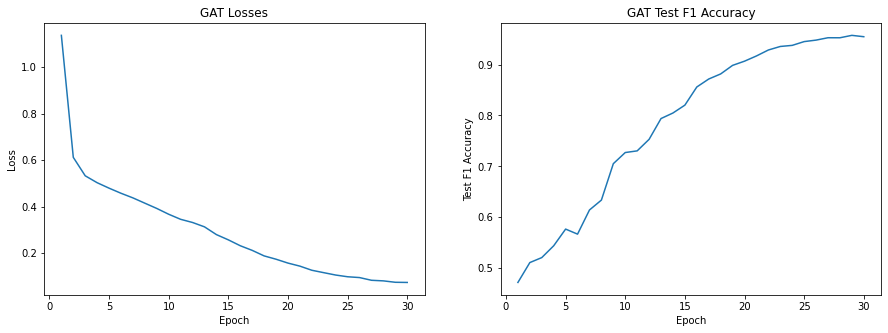

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(GAT_Epochs, GAT_Loss)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('GAT Losses')

ax2.plot(GAT_Epochs, GAT_TestF1)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Test F1 Accuracy')
ax2.set_title('GAT Test F1 Accuracy')

fig1 = ax1.get_figure()
fig1.savefig('GAT_Performance.png')
files.download('GAT_Performance.png')

plt.show()

##5 - Implementing FiLMConv Architecture for Multi-Label Node Classification

Followed a similar process to perform the multi-label node classification on a different architecture.

In [ ]:
from torch.nn import BatchNorm1d
from torch_geometric.nn import FiLMConv

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout=0.0):
        super().__init__()
        self.dropout = dropout
#create a list of FiLMConv layers
        self.convs = torch.nn.ModuleList()
#The first layer takes the input channels and maps them to the hidden channels.
        self.convs.append(FiLMConv(in_channels, hidden_channels))
#The next num_layers-2 layers take the hidden channels and map them to the hidden channels.
        for _ in range(num_layers - 2):
            self.convs.append(FiLMConv(hidden_channels, hidden_channels))
#The final layer takes the hidden channels and maps them to the output channels.
        self.convs.append(FiLMConv(hidden_channels, out_channels, act=None))
#A list of batch normalization layers, using BatchNorm1d, is created with num_layers-1 elements.
        self.norms = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            self.norms.append(BatchNorm1d(hidden_channels))
#features and edges passed through, applying normalization and dropout, final output of network is returned
    def forward(self, x, edge_index):
        for conv, norm in zip(self.convs[:-1], self.norms):

            x = norm(conv(x, edge_index))
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(in_channels=train_dataset.num_features, hidden_channels=320,
            out_channels=train_dataset.num_classes, num_layers=4,
            dropout=0.1).to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(in_channels=train_dataset.num_features, hidden_channels=320,
            out_channels=train_dataset.num_classes, num_layers=4,
            dropout=0.1).to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005) #0.005

@torch.no_grad()
def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        out = model(data.x.to(device), data.edge_index.to(device))
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

In [ ]:
FiLM_Epochs = []
FiLM_Loss = []
FiLM_ValF1 = []
FiLM_TestF1 = []
for epoch in range(1, 31):
    loss = train()
    val_f1 = test(val_loader)
    test_f1 = test(test_loader)
    FiLM_Epochs.append(epoch)
    FiLM_Loss.append(loss)
    FiLM_ValF1.append(val_f1)
    FiLM_TestF1.append(test_f1)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val: {val_f1:.4f}, '
          f'Test: {test_f1:.4f}')

Epoch: 01, Loss: 0.7239, Val: 0.4180, Test: 0.4199
Epoch: 02, Loss: 0.5640, Val: 0.4582, Test: 0.4596
Epoch: 03, Loss: 0.5273, Val: 0.4882, Test: 0.4939
Epoch: 04, Loss: 0.4972, Val: 0.5266, Test: 0.5341
Epoch: 05, Loss: 0.4735, Val: 0.5579, Test: 0.5692
Epoch: 06, Loss: 0.4496, Val: 0.6056, Test: 0.6196
Epoch: 07, Loss: 0.4277, Val: 0.6047, Test: 0.6206
Epoch: 08, Loss: 0.4046, Val: 0.6356, Test: 0.6534
Epoch: 09, Loss: 0.3844, Val: 0.6693, Test: 0.6877
Epoch: 10, Loss: 0.3673, Val: 0.6910, Test: 0.7091
Epoch: 11, Loss: 0.3529, Val: 0.7136, Test: 0.7312
Epoch: 12, Loss: 0.3347, Val: 0.7317, Test: 0.7519
Epoch: 13, Loss: 0.3151, Val: 0.7433, Test: 0.7650
Epoch: 14, Loss: 0.2986, Val: 0.7650, Test: 0.7858
Epoch: 15, Loss: 0.2827, Val: 0.7896, Test: 0.8102
Epoch: 16, Loss: 0.2689, Val: 0.8013, Test: 0.8228
Epoch: 17, Loss: 0.2549, Val: 0.8065, Test: 0.8274
Epoch: 18, Loss: 0.2485, Val: 0.8228, Test: 0.8425
Epoch: 19, Loss: 0.2439, Val: 0.8291, Test: 0.8477
Epoch: 20, Loss: 0.2349, Val: 0

Visualisation of performance:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

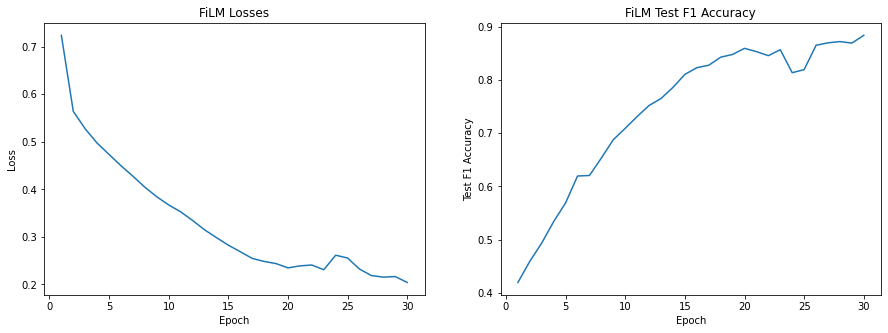

In [ ]:
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(15,5))

ax3.plot(FiLM_Epochs, FiLM_Loss)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.set_title('FiLM Losses')


ax4.plot(FiLM_Epochs, FiLM_TestF1)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Test F1 Accuracy')
ax4.set_title('FiLM Test F1 Accuracy')

fig2 = ax4.get_figure()
fig2.savefig('FiLM_Performance.png')
files.download('FiLM_Performance.png')

plt.show()






##6 - Implementing GraphSage Architecture for Link Prediction

In [ ]:
import tqdm #progress bar
from sklearn.linear_model import SGDClassifier
from sklearn.multioutput import MultiOutputClassifier

from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader, LinkNeighborLoader
from torch_geometric.nn import GraphSAGE

In [ ]:
# Group all training graphs into a single graph to perform sampling:
train_data = Batch.from_data_list(train_dataset)
#ratio of negative samples to positive #each node 10 neighbours sampled for each layer
#The LinkNeighborLoader object creates mini-batches by sampling edges and their adjacent nodes.
loader = LinkNeighborLoader(train_data, batch_size=2048, shuffle=True,
                            neg_sampling_ratio=1.0, num_neighbors=[10, 10],
                            num_workers=6, persistent_workers=True)

# Creates three DataLoaders for the training, validation, and test datasets, each with a batch size of 2.
train_loader = DataLoader(train_dataset, batch_size=2)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#GraphSAGE model with the number of input channels equal to the number of features in the training dataset,
#64 hidden channels, 2 layers, and 64 output channels. The model is then moved to the specified device
model = GraphSAGE(
    in_channels=train_dataset.num_features,
    hidden_channels=64,
    num_layers=2,
    out_channels=64,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def train():
    model.train()

    total_loss = total_examples = 0
    for data in tqdm.tqdm(loader):
        data = data.to(device)
        optimizer.zero_grad()
        #model forward propagated with input data "data.x" and the edge indices "data.edge_index".
        h = model(data.x, data.edge_index)
        #The source and destination node embeddings "h_src" and "h_dst" are calculated by indexing the output of the model "h".
        h_src = h[data.edge_label_index[0]]
        h_dst = h[data.edge_label_index[1]]
        link_pred = (h_src * h_dst).sum(dim=-1)  # Inner product. Understand distance in space # done along feature dimension

        loss = F.binary_cross_entropy_with_logits(link_pred, data.edge_label)
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * link_pred.numel()
        total_examples += link_pred.numel()

    return total_loss / total_examples

In [ ]:
@torch.no_grad()
def encode(loader):
    model.eval()

    xs, ys = [], []
    for data in loader:
        data = data.to(device)
        xs.append(model(data.x, data.edge_index).cpu())
        ys.append(data.y.cpu())
    return torch.cat(xs, dim=0), torch.cat(ys, dim=0)


@torch.no_grad()
def test():
    # Train classifier on training set:
    x, y = encode(train_loader)

    clf = MultiOutputClassifier(SGDClassifier(loss='log', penalty='l2'))
    clf.fit(x, y)

    train_f1 = f1_score(y, clf.predict(x), average='micro')

    # Evaluate on validation set:
    x, y = encode(val_loader)
    val_f1 = f1_score(y, clf.predict(x), average='micro')

    # Evaluate on test set:
    x, y = encode(test_loader)
    test_f1 = f1_score(y, clf.predict(x), average='micro')

    return train_f1, val_f1, test_f1

In [ ]:
Sage_Epochs = []
Sage_Loss = []
Sage_ValF1 = []
Sage_TestF1 = []

for epoch in range(1, 6):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')
    train_f1, val_f1, test_f1 = test()
    print(f'Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, '
          f'Test F1: {test_f1:.4f}')
    Sage_Epochs.append(epoch)
    Sage_Loss.append(loss)
    Sage_ValF1.append(val_f1)
    Sage_TestF1.append(test_f1)

100%|██████████| 599/599 [08:21<00:00,  1.19it/s]


Epoch: 01, Loss: 0.6046
Train F1: 0.5184, Val F1: 0.5130, Test F1: 0.5153


100%|██████████| 599/599 [08:19<00:00,  1.20it/s]


Epoch: 02, Loss: 0.5739
Train F1: 0.5183, Val F1: 0.5124, Test F1: 0.5166


100%|██████████| 599/599 [08:19<00:00,  1.20it/s]


Epoch: 03, Loss: 0.5688
Train F1: 0.5246, Val F1: 0.5170, Test F1: 0.5228


100%|██████████| 599/599 [08:12<00:00,  1.22it/s]


Epoch: 04, Loss: 0.5662
Train F1: 0.5202, Val F1: 0.5102, Test F1: 0.5156


100%|██████████| 599/599 [08:14<00:00,  1.21it/s]


Epoch: 05, Loss: 0.5652
Train F1: 0.5292, Val F1: 0.5204, Test F1: 0.5266


Visualisation of performance:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

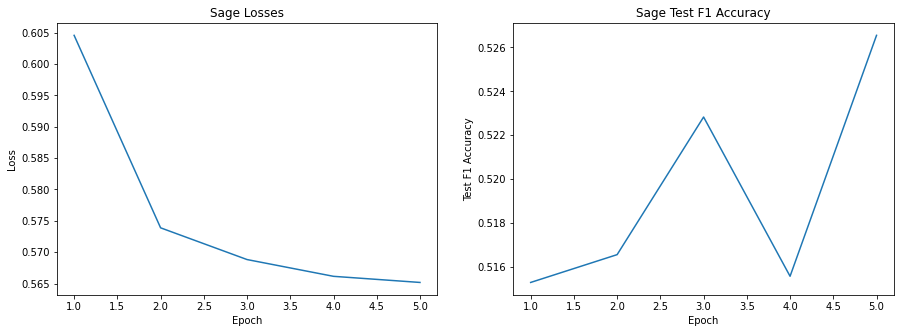

In [ ]:
fig3, (ax5, ax6) = plt.subplots(1, 2, figsize=(15,5))

ax5.plot(Sage_Epochs, Sage_Loss)
ax5.set_xlabel('Epoch')
ax5.set_ylabel('Loss')
ax5.set_title('Sage Losses')


ax6.plot(Sage_Epochs, Sage_TestF1)
ax6.set_xlabel('Epoch')
ax6.set_ylabel('Test F1 Accuracy')
ax6.set_title('Sage Test F1 Accuracy')

fig3 = ax6.get_figure()
fig3.savefig('Sage_Performance.png')
files.download('Sage_Performance.png')

plt.show()
